In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_calcver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'train_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'train_mass_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_calcver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'test_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'test_mass_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1535 	 Test size: 337
Image size: 256x256


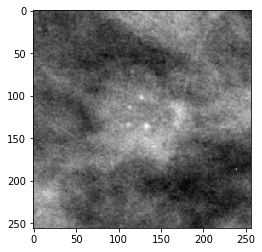

Label: 0


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1535, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [12]:
vgg = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg16_calc_benign_or_malignant_best_Adam = new_vgg

In [14]:
vgg16_calc_benign_or_malignant_best_RMSprop = new_vgg

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg16_calc_benign_or_malignant_best_Adam = vgg16_calc_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 3.8130 - recall: 0.5547
Epoch 00001: val_loss improved from inf to 1.33557, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 17s 3s/step - loss: 3.2425 - recall: 0.5703 - val_loss: 1.3356 - val_recall: 0.4951
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1341 - recall: 0.5879
Epoch 00002: val_loss improved from 1.33557 to 0.92679, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1486 - recall: 0.5844 - val_loss: 0.9268 - val_recall: 0.6612
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7860 - recall: 0.6504
Epoch 00003: val_loss improved from 0.92679 to 0.62438, saving model 

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5251 - recall: 0.7090
Epoch 00028: val_loss did not improve from 0.51779
5/5 [==============================] - 10s 2s/step - loss: 0.5249 - recall: 0.7092 - val_loss: 0.5333 - val_recall: 0.7394
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4880 - recall: 0.7363
Epoch 00029: val_loss did not improve from 0.51779
5/5 [==============================] - 11s 2s/step - loss: 0.4865 - recall: 0.7219 - val_loss: 0.5450 - val_recall: 0.7296
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4669 - recall: 0.7520
Epoch 00030: val_loss did not improve from 0.51779
5/5 [==============================] - 11s 2s/step - loss: 0.4850 - recall: 0.7437 - val_loss: 0.5548 - val_recall: 0.7264
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4991 - recall: 0.7239
Epoch 00031: val_loss did not improve from 0.51779
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4988 - recall: 0.7326
Epoch 00059: val_loss did not improve from 0.49978
5/5 [==============================] - 10s 2s/step - loss: 0.4901 - recall: 0.7381 - val_loss: 0.5579 - val_recall: 0.7329
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4626 - recall: 0.7370
Epoch 00060: val_loss did not improve from 0.49978
5/5 [==============================] - 10s 2s/step - loss: 0.4512 - recall: 0.7517 - val_loss: 0.5261 - val_recall: 0.7264
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4612 - recall: 0.7543
Epoch 00061: val_loss did not improve from 0.49978
5/5 [==============================] - 10s 2s/step - loss: 0.4712 - recall: 0.7483 - val_loss: 0.5480 - val_recall: 0.7459
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4855 - recall: 0.7578
Epoch 00062: val_loss did not improve from 0.49978
5/5 [==============================] - 11s 2s/step - loss: 

In [17]:
models.save_model(vgg16_calc_benign_or_malignant_best_Adam, '../model/vgg16_calc_benign_or_malignant_end_Adam.h5')

In [18]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 71
Epoch [opt]: 41
Valid accuracy [end]: 0.7557
Valid accuracy [opt]: 0.7459
Test accuracy [end]:  0.6766
Test accuracy [opt]:  0.7151
Valid loss [end]: 0.5112
Valid loss [opt]: 0.4998
Test loss [end]:  0.5660
Test loss [opt]:  0.5370


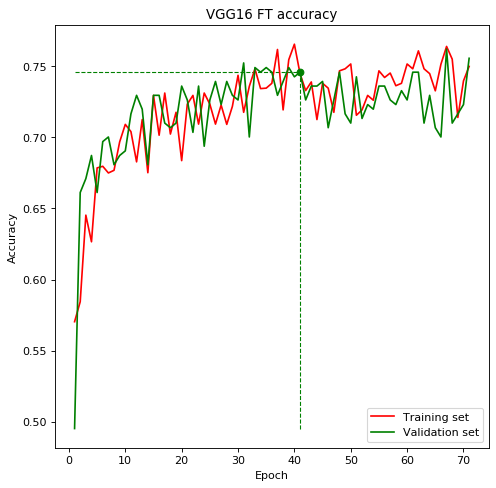

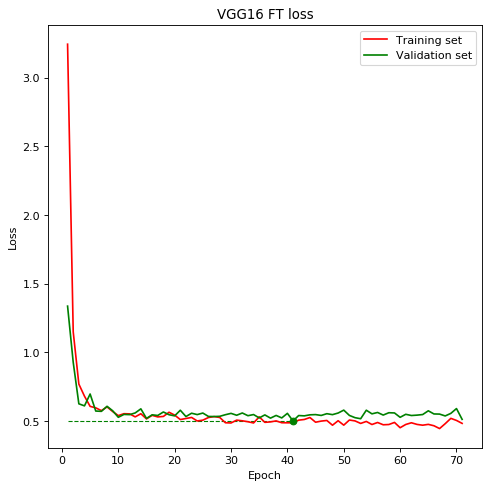

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
vgg16_calc_benign_or_malignant_best_SGD = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg16_calc_benign_or_malignant_best_SGD = vgg16_calc_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4007 - recall: 0.5371
Epoch 00001: val_loss improved from inf to 1.14013, saving model to ../model/vgg16_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 1.3921 - recall: 0.5312 - val_loss: 1.1401 - val_recall: 0.5407
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4778 - recall: 0.5215
Epoch 00002: val_loss improved from 1.14013 to 1.08811, saving model to ../model/vgg16_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 1.4081 - recall: 0.5422 - val_loss: 1.0881 - val_recall: 0.5309
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3434 - recall: 0.5508
Epoch 00003: val_loss improved from 1.08811 to 0.91079, saving model to ../model/vgg16_calc_benign_or_malignant_best_SGD.h5
5/5 [==================

4/5 [=======================>......] - ETA: 1s - loss: 1.0301 - recall: 0.6250
Epoch 00058: val_loss did not improve from 0.63794
5/5 [==============================] - 12s 2s/step - loss: 1.0422 - recall: 0.6141 - val_loss: 0.8326 - val_recall: 0.6678
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8763 - recall: 0.6641
Epoch 00059: val_loss did not improve from 0.63794
5/5 [==============================] - 11s 2s/step - loss: 0.9175 - recall: 0.6453 - val_loss: 0.7039 - val_recall: 0.6645
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8830 - recall: 0.6602
Epoch 00060: val_loss improved from 0.63794 to 0.63465, saving model to ../model/vgg16_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 0.8741 - recall: 0.6578 - val_loss: 0.6346 - val_recall: 0.7068
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8513 - recall: 0.6783
Epoch 00061: val_loss did not improve from 0.63465

4/5 [=======================>......] - ETA: 1s - loss: 0.8679 - recall: 0.6426
Epoch 00088: val_loss did not improve from 0.61105
5/5 [==============================] - 11s 2s/step - loss: 0.8718 - recall: 0.6547 - val_loss: 0.7251 - val_recall: 0.7068
Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8389 - recall: 0.6426
Epoch 00089: val_loss did not improve from 0.61105
5/5 [==============================] - 12s 2s/step - loss: 0.8577 - recall: 0.6438 - val_loss: 0.6839 - val_recall: 0.6971
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0363 - recall: 0.6348
Epoch 00090: val_loss did not improve from 0.61105
5/5 [==============================] - 12s 2s/step - loss: 0.9858 - recall: 0.6469 - val_loss: 0.6702 - val_recall: 0.6808
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8979 - recall: 0.6641
Epoch 00091: val_loss did not improve from 0.61105
5/5 [==============================] - 12s 2s/step - loss: 0.8652 - reca

Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7973 - recall: 0.6696
Epoch 00119: val_loss did not improve from 0.60216
5/5 [==============================] - 10s 2s/step - loss: 0.8596 - recall: 0.6395 - val_loss: 0.6739 - val_recall: 0.7134
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9026 - recall: 0.6543
Epoch 00120: val_loss did not improve from 0.60216
5/5 [==============================] - 11s 2s/step - loss: 0.9263 - recall: 0.6453 - val_loss: 0.6492 - val_recall: 0.7003
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9135 - recall: 0.6406
Epoch 00121: val_loss improved from 0.60216 to 0.60153, saving model to ../model/vgg16_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 0.9199 - recall: 0.6406 - val_loss: 0.6015 - val_recall: 0.6775
Epoch 122/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0125 - recall: 0.5996
Epoch 00122: val_loss did not imp

Epoch 149/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8058 - recall: 0.6761
Epoch 00149: val_loss did not improve from 0.58674
5/5 [==============================] - 10s 2s/step - loss: 0.7934 - recall: 0.6769 - val_loss: 0.6525 - val_recall: 0.6580
Epoch 150/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8256 - recall: 0.6261
Epoch 00150: val_loss did not improve from 0.58674
5/5 [==============================] - 10s 2s/step - loss: 0.7920 - recall: 0.6480 - val_loss: 0.6271 - val_recall: 0.6710
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7999 - recall: 0.6848
Epoch 00151: val_loss did not improve from 0.58674
5/5 [==============================] - 10s 2s/step - loss: 0.8000 - recall: 0.6803 - val_loss: 0.6513 - val_recall: 0.6840
Epoch 152/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8282 - recall: 0.6804
Epoch 00152: val_loss did not improve from 0.58674
5/5 [==============================] - 10s 2s/step - lo

In [24]:
models.save_model(vgg16_calc_benign_or_malignant_best_SGD, '../model/vgg16_calc_benign_or_malignant_end_SGD.h5')

In [25]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 156
Epoch [opt]: 126
Valid accuracy [end]: 0.6873
Valid accuracy [opt]: 0.7101
Test accuracy [end]:  0.6825
Test accuracy [opt]:  0.6855
Valid loss [end]: 0.6490
Valid loss [opt]: 0.5867
Test loss [end]:  0.6642
Test loss [opt]:  0.6769


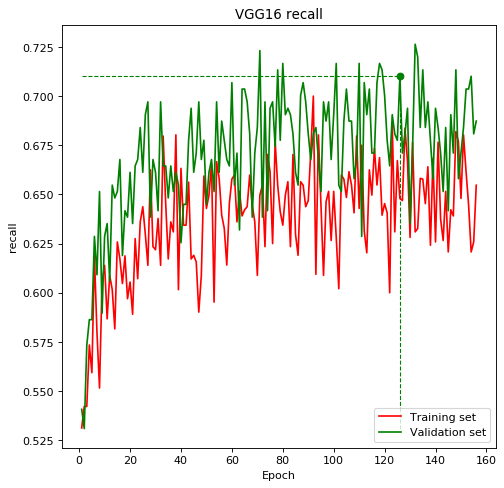

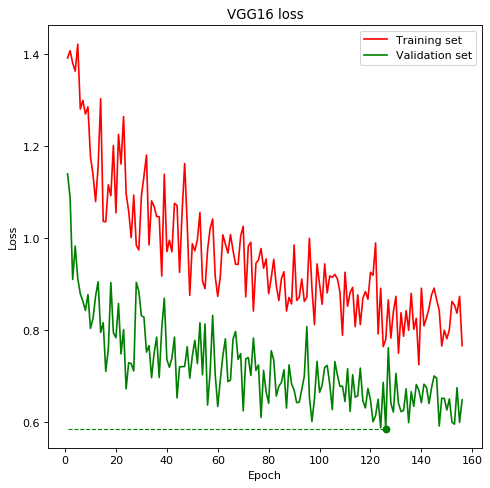

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_vgg16_calc_benign_or_malignant_best_RMSprop = vgg16_calc_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6500 - recall: 0.6826
Epoch 00001: val_loss improved from inf to 0.54829, saving model to ../model/vgg16_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6199 - recall: 0.6820 - val_loss: 0.5483 - val_recall: 0.7362
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5033 - recall: 0.7402
Epoch 00002: val_loss did not improve from 0.54829
5/5 [==============================] - 12s 2s/step - loss: 0.5079 - recall: 0.7328 - val_loss: 0.6637 - val_recall: 0.6808
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5339 - recall: 0.6953
Epoch 00003: val_loss improved from 0.54829 to 0.53851, saving model to ../model/vgg16_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 12s 2s/step - loss: 0.5175 - recall: 0.7156 - val

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4580 - recall: 0.7715
Epoch 00060: val_loss did not improve from 0.48470
5/5 [==============================] - 11s 2s/step - loss: 0.4563 - recall: 0.7688 - val_loss: 0.5611 - val_recall: 0.7394
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4503 - recall: 0.7598
Epoch 00061: val_loss did not improve from 0.48470
5/5 [==============================] - 11s 2s/step - loss: 0.4561 - recall: 0.7609 - val_loss: 0.6124 - val_recall: 0.7166
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4440 - recall: 0.7852
Epoch 00062: val_loss did not improve from 0.48470
5/5 [==============================] - 11s 2s/step - loss: 0.4548 - recall: 0.7721 - val_loss: 0.5522 - val_recall: 0.7329
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4426 - recall: 0.7832
Epoch 00063: val_loss did not improve from 0.48470
5/5 [==============================] - 11s 2s/step - loss: 

In [29]:
models.save_model(vgg16_calc_benign_or_malignant_best_RMSprop, '../model/vgg16_calc_benign_or_malignant_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 89
Epoch [opt]: 59
Valid accuracy [end]: 0.7231
Valid accuracy [opt]: 0.7590
Test accuracy [end]:  0.7211
Test accuracy [opt]:  0.7240
Valid loss [end]: 0.5295
Valid loss [opt]: 0.4847
Test loss [end]:  0.5435
Test loss [opt]:  0.5611


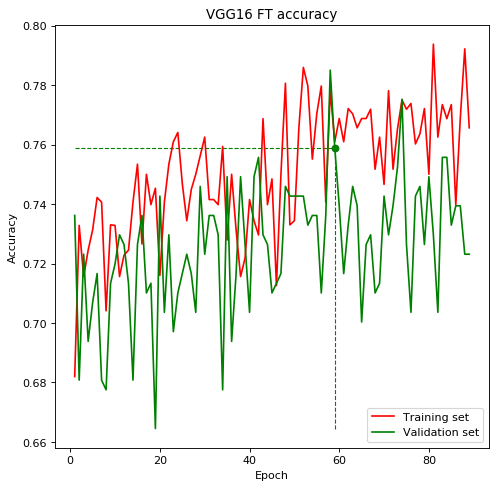

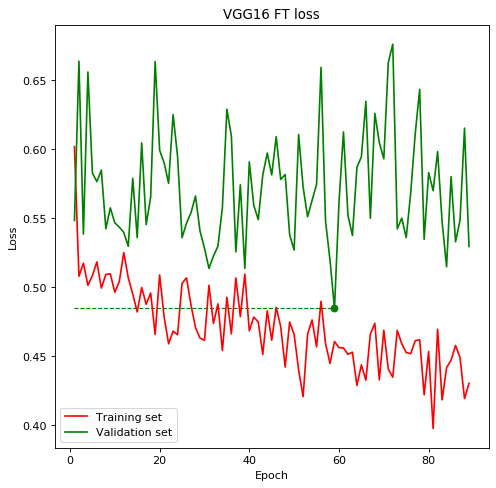

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
vgg16_calc_benign_or_malignant_best_Adadelta = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_vgg16_calc_benign_or_malignant_best_Adadelta = vgg16_calc_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.7057 - recall: 0.4283
Epoch 00001: val_loss improved from inf to 1.32955, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 12s 2s/step - loss: 1.7332 - recall: 0.4184 - val_loss: 1.3296 - val_recall: 0.4039
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.7837 - recall: 0.4435
Epoch 00002: val_loss improved from 1.32955 to 1.17914, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 12s 2s/step - loss: 1.7121 - recall: 0.4558 - val_loss: 1.1791 - val_recall: 0.4691
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5302 - recall: 0.4696
Epoch 00003: val_loss did not improve from 1.17914
5/5 [==============================] - 11s 2s/step - loss: 1.5850 - recall: 0.4609 - v

4/5 [=======================>......] - ETA: 1s - loss: 1.4258 - recall: 0.5326
Epoch 00029: val_loss did not improve from 0.84536
5/5 [==============================] - 10s 2s/step - loss: 1.3393 - recall: 0.5323 - val_loss: 0.9571 - val_recall: 0.5505
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5787 - recall: 0.4648
Epoch 00030: val_loss did not improve from 0.84536
5/5 [==============================] - 10s 2s/step - loss: 1.5296 - recall: 0.4626 - val_loss: 0.9090 - val_recall: 0.5831
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4977 - recall: 0.4961
Epoch 00031: val_loss did not improve from 0.84536
5/5 [==============================] - 11s 2s/step - loss: 1.5233 - recall: 0.4906 - val_loss: 0.8572 - val_recall: 0.5505
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4703 - recall: 0.5215
Epoch 00032: val_loss did not improve from 0.84536
5/5 [==============================] - 11s 2s/step - loss: 1.4399 - reca

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4513 - recall: 0.5217
Epoch 00060: val_loss did not improve from 0.76759
5/5 [==============================] - 10s 2s/step - loss: 1.4523 - recall: 0.5289 - val_loss: 1.0549 - val_recall: 0.5375
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3721 - recall: 0.5801
Epoch 00061: val_loss did not improve from 0.76759
5/5 [==============================] - 11s 2s/step - loss: 1.3760 - recall: 0.5656 - val_loss: 0.8685 - val_recall: 0.5440
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3231 - recall: 0.5469
Epoch 00062: val_loss did not improve from 0.76759
5/5 [==============================] - 11s 2s/step - loss: 1.2515 - recall: 0.5531 - val_loss: 0.8801 - val_recall: 0.5993
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2252 - recall: 0.5742
Epoch 00063: val_loss did not improve from 0.76759
5/5 [==============================] - 10s 2s/step - loss: 

In [34]:
models.save_model(vgg16_calc_benign_or_malignant_best_Adadelta, '../model/vgg16_calc_benign_or_malignant_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 85
Epoch [opt]: 55
Valid accuracy [end]: 0.6091
Valid accuracy [opt]: 0.5993
Test accuracy [end]:  0.6469
Test accuracy [opt]:  0.6320
Valid loss [end]: 0.9229
Valid loss [opt]: 0.7676
Test loss [end]:  0.9302
Test loss [opt]:  0.9245


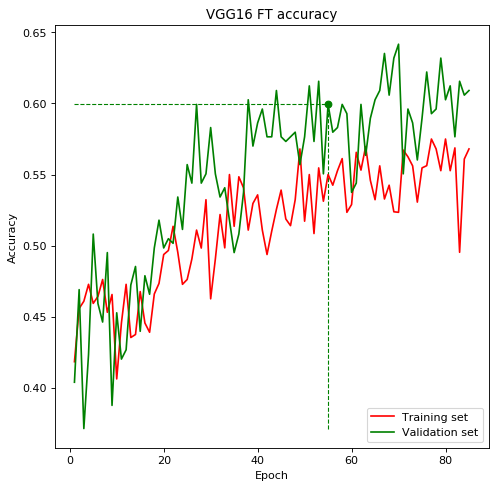

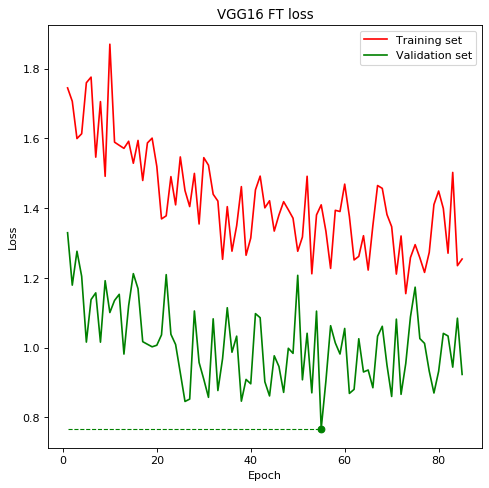

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
vgg16_calc_benign_or_malignant_best_Adagrad = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_calc_benign_or_malignant_best_Adagrad = vgg16_calc_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.8498 - recall: 0.5000
Epoch 00001: val_loss improved from inf to 1.06956, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 19s 4s/step - loss: 1.7888 - recall: 0.5102 - val_loss: 1.0696 - val_recall: 0.5961
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4205 - recall: 0.5761
Epoch 00002: val_loss improved from 1.06956 to 0.72867, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 1.4162 - recall: 0.5663 - val_loss: 0.7287 - val_recall: 0.6840
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1126 - recall: 0.6504
Epoch 00003: val_loss did not improve from 0.72867
5/5 [=======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9329 - recall: 0.6309
Epoch 00029: val_loss did not improve from 0.62143
5/5 [==============================] - 10s 2s/step - loss: 0.8896 - recall: 0.6438 - val_loss: 0.7423 - val_recall: 0.6775
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8327 - recall: 0.6630
Epoch 00030: val_loss did not improve from 0.62143
5/5 [==============================] - 10s 2s/step - loss: 0.8152 - recall: 0.6616 - val_loss: 0.7277 - val_recall: 0.6645
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9742 - recall: 0.6289
Epoch 00031: val_loss did not improve from 0.62143
5/5 [==============================] - 10s 2s/step - loss: 0.9416 - recall: 0.6375 - val_loss: 0.6964 - val_recall: 0.7036
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8627 - recall: 0.6761
Epoch 00032: val_loss did not improve from 0.62143
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8904 - recall: 0.6465
Epoch 00060: val_loss improved from 0.57950 to 0.54707, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 0.9047 - recall: 0.6453 - val_loss: 0.5471 - val_recall: 0.7134
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8783 - recall: 0.6587
Epoch 00061: val_loss did not improve from 0.54707
5/5 [==============================] - 10s 2s/step - loss: 0.9005 - recall: 0.6565 - val_loss: 0.6160 - val_recall: 0.6971
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7369 - recall: 0.6484
Epoch 00062: val_loss did not improve from 0.54707
5/5 [==============================] - 10s 2s/step - loss: 0.7575 - recall: 0.6514 - val_loss: 0.5845 - val_recall: 0.6938
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8793 - recall: 0.6435
Epoch 00063: val_loss did not imp

Epoch 00090: early stopping


In [15]:
models.save_model(vgg16_calc_benign_or_malignant_best_Adagrad, '../model/vgg16_calc_benign_or_malignant_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 90
Epoch [opt]: 60
Valid accuracy [end]: 0.7329
Valid accuracy [opt]: 0.7134
Test accuracy [end]:  0.6944
Test accuracy [opt]:  0.6588
Valid loss [end]: 0.6826
Valid loss [opt]: 0.5471
Test loss [end]:  0.7030
Test loss [opt]:  0.7740


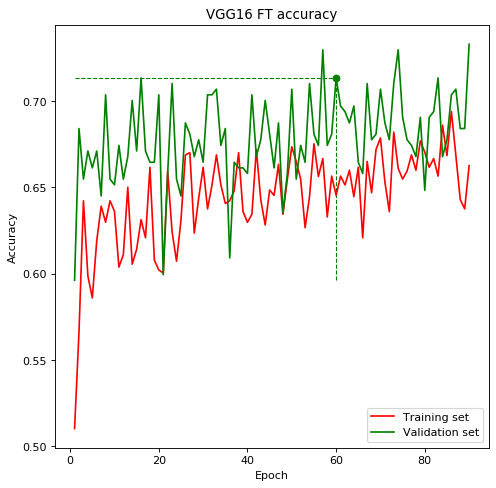

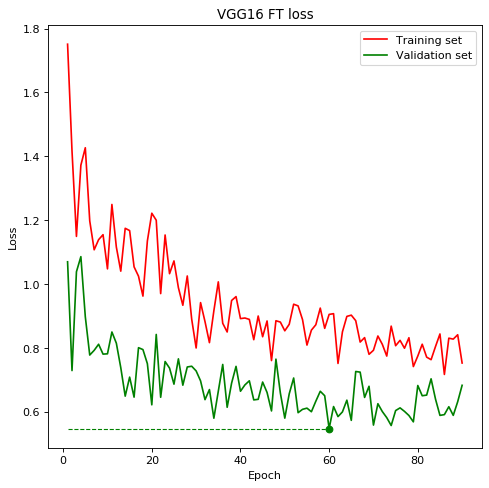

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
vgg16_calc_benign_or_malignant_best_Adamax = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg16_calc_benign_or_malignant_best_Adamax = vgg16_calc_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 2.4144 - recall: 0.5000
Epoch 00001: val_loss improved from inf to 1.30889, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 2.1935 - recall: 0.5375 - val_loss: 1.3089 - val_recall: 0.6384
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3312 - recall: 0.6522
Epoch 00002: val_loss improved from 1.30889 to 0.62801, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.2044 - recall: 0.6650 - val_loss: 0.6280 - val_recall: 0.6808
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0601 - recall: 0.6309
Epoch 00003: val_loss did not improve from 0.62801
5/5 [==============================] - 11s 2s/step - loss: 1.0569 - recall: 0.6219 - val_l

5/5 [==============================] - 11s 2s/step - loss: 0.5684 - recall: 0.6888 - val_loss: 0.5287 - val_recall: 0.7036
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6465 - recall: 0.6797
Epoch 00029: val_loss improved from 0.52869 to 0.52069, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 12s 2s/step - loss: 0.6604 - recall: 0.6844 - val_loss: 0.5207 - val_recall: 0.7036
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6881 - recall: 0.6719
Epoch 00030: val_loss did not improve from 0.52069
5/5 [==============================] - 11s 2s/step - loss: 0.6667 - recall: 0.6781 - val_loss: 0.5495 - val_recall: 0.7101
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6189 - recall: 0.7000
Epoch 00031: val_loss did not improve from 0.52069
5/5 [==============================] - 10s 2s/step - loss: 0.6042 - recall: 0.7007 - val_loss: 0.5265 - val_recall: 0.7003
Epo

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5933 - recall: 0.6826
Epoch 00059: val_loss improved from 0.51053 to 0.50350, saving model to ../model/vgg16_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 10s 2s/step - loss: 0.6000 - recall: 0.6684 - val_loss: 0.5035 - val_recall: 0.7687
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5551 - recall: 0.6895
Epoch 00060: val_loss did not improve from 0.50350
5/5 [==============================] - 11s 2s/step - loss: 0.5489 - recall: 0.7031 - val_loss: 0.5109 - val_recall: 0.7068
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6057 - recall: 0.6717
Epoch 00061: val_loss did not improve from 0.50350
5/5 [==============================] - 10s 2s/step - loss: 0.5891 - recall: 0.6769 - val_loss: 0.5095 - val_recall: 0.7362
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5586 - recall: 0.7090
Epoch 00062: val_loss did not impr

Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5304 - recall: 0.7043
Epoch 00089: val_loss did not improve from 0.47850
5/5 [==============================] - 11s 2s/step - loss: 0.5239 - recall: 0.7177 - val_loss: 0.4973 - val_recall: 0.7557
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5247 - recall: 0.7304
Epoch 00090: val_loss did not improve from 0.47850
5/5 [==============================] - 10s 2s/step - loss: 0.5258 - recall: 0.7211 - val_loss: 0.5303 - val_recall: 0.7394
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5228 - recall: 0.6957
Epoch 00091: val_loss did not improve from 0.47850
5/5 [==============================] - 10s 2s/step - loss: 0.5135 - recall: 0.7143 - val_loss: 0.5204 - val_recall: 0.7231
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5567 - recall: 0.7109
Epoch 00092: val_loss did not improve from 0.47850
5/5 [==============================] - 10s 2s/step - loss: 

In [20]:
models.save_model(vgg16_calc_benign_or_malignant_best_Adamax, '../model/vgg16_calc_benign_or_malignant_end_Adamax.h5')

In [21]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 115
Epoch [opt]: 85
Valid accuracy [end]: 0.7590
Valid accuracy [opt]: 0.7264
Test accuracy [end]:  0.7092
Test accuracy [opt]:  0.7151
Valid loss [end]: 0.4843
Valid loss [opt]: 0.4785
Test loss [end]:  0.5211
Test loss [opt]:  0.5271


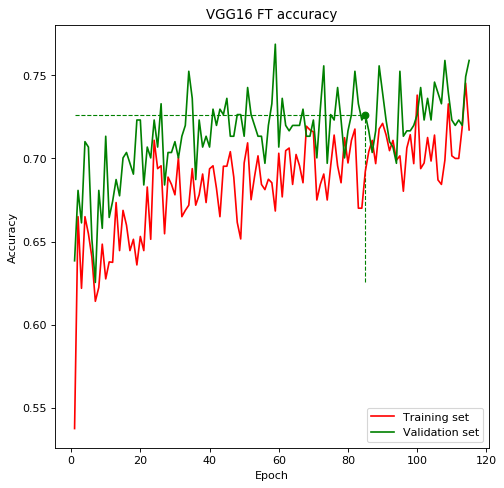

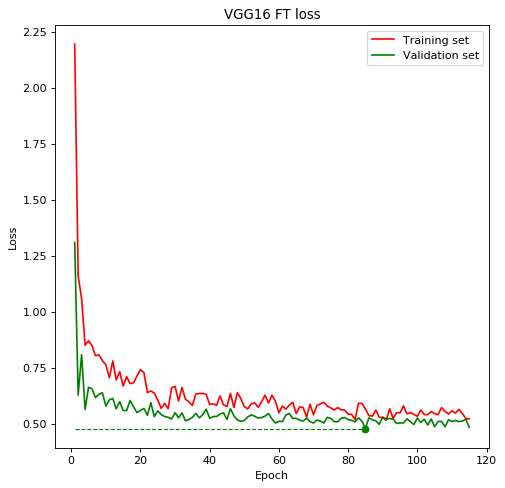

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [13]:
vgg16_calc_benign_or_malignant_best_Nadam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_calc_benign_or_malignant_best_Nadam = vgg16_calc_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.7509 - recall: 0.5804
Epoch 00001: val_loss improved from inf to 0.79364, saving model to ../model/vgg16_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 18s 4s/step - loss: 1.6214 - recall: 0.5833 - val_loss: 0.7936 - val_recall: 0.6938
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0596 - recall: 0.6191
Epoch 00002: val_loss improved from 0.79364 to 0.76938, saving model to ../model/vgg16_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0408 - recall: 0.6172 - val_loss: 0.7694 - val_recall: 0.6352
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9384 - recall: 0.6406
Epoch 00003: val_loss did not improve from 0.76938
5/5 [===========

4/5 [=======================>......] - ETA: 1s - loss: 0.5182 - recall: 0.7413
Epoch 00057: val_loss did not improve from 0.48912
5/5 [==============================] - 10s 2s/step - loss: 0.5245 - recall: 0.7313 - val_loss: 0.5041 - val_recall: 0.7362
Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5345 - recall: 0.7109
Epoch 00058: val_loss did not improve from 0.48912
5/5 [==============================] - 10s 2s/step - loss: 0.5278 - recall: 0.7125 - val_loss: 0.5412 - val_recall: 0.7231
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5269 - recall: 0.7031
Epoch 00059: val_loss did not improve from 0.48912
5/5 [==============================] - 11s 2s/step - loss: 0.5410 - recall: 0.6906 - val_loss: 0.4894 - val_recall: 0.7264
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5161 - recall: 0.7391
Epoch 00060: val_loss did not improve from 0.48912
5/5 [==============================] - 10s 2s/step - loss: 0.5288 - reca

4/5 [=======================>......] - ETA: 1s - loss: 0.5089 - recall: 0.7051
Epoch 00087: val_loss did not improve from 0.48464
5/5 [==============================] - 11s 2s/step - loss: 0.5151 - recall: 0.7094 - val_loss: 0.5100 - val_recall: 0.7264
Epoch 88/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4702 - recall: 0.7559
Epoch 00088: val_loss did not improve from 0.48464
5/5 [==============================] - 10s 2s/step - loss: 0.4782 - recall: 0.7484 - val_loss: 0.4847 - val_recall: 0.7720
Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4912 - recall: 0.7522
Epoch 00089: val_loss did not improve from 0.48464
5/5 [==============================] - 10s 2s/step - loss: 0.4977 - recall: 0.7483 - val_loss: 0.4897 - val_recall: 0.7362
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4958 - recall: 0.7348
Epoch 00090: val_loss did not improve from 0.48464
5/5 [==============================] - 10s 2s/step - loss: 0.4983 - reca

Epoch 118/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4679 - recall: 0.7348
Epoch 00118: val_loss did not improve from 0.48310
5/5 [==============================] - 10s 2s/step - loss: 0.4795 - recall: 0.7364 - val_loss: 0.5028 - val_recall: 0.7166
Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4832 - recall: 0.7261
Epoch 00119: val_loss did not improve from 0.48310
5/5 [==============================] - 10s 2s/step - loss: 0.4871 - recall: 0.7330 - val_loss: 0.5567 - val_recall: 0.7166
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5084 - recall: 0.7168
Epoch 00120: val_loss did not improve from 0.48310
5/5 [==============================] - 10s 2s/step - loss: 0.4962 - recall: 0.7344 - val_loss: 0.5153 - val_recall: 0.7036
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4817 - recall: 0.7324
Epoch 00121: val_loss did not improve from 0.48310
5/5 [==============================] - 10s 2s/step - lo

In [15]:
models.save_model(vgg16_calc_benign_or_malignant_best_Nadam, '../model/vgg16_calc_benign_or_malignant_end_Nadam.h5')

In [16]:
tra_loss_fe = history_vgg16_calc_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_vgg16_calc_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_vgg16_calc_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_vgg16_calc_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_benign_or_malignant = models.load_model('../model/vgg16_calc_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 126
Epoch [opt]: 96
Valid accuracy [end]: 0.7296
Valid accuracy [opt]: 0.7524
Test accuracy [end]:  0.7092
Test accuracy [opt]:  0.7033
Valid loss [end]: 0.5026
Valid loss [opt]: 0.4831
Test loss [end]:  0.4950
Test loss [opt]:  0.5088


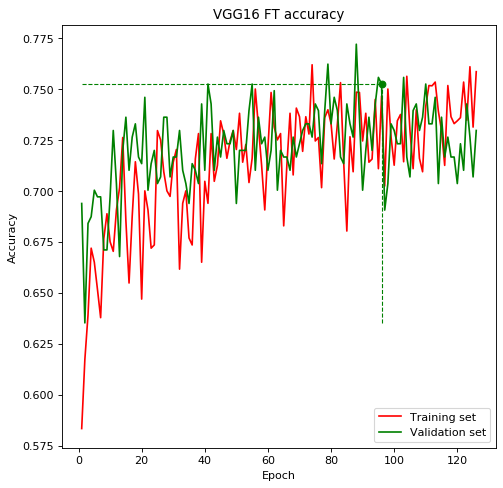

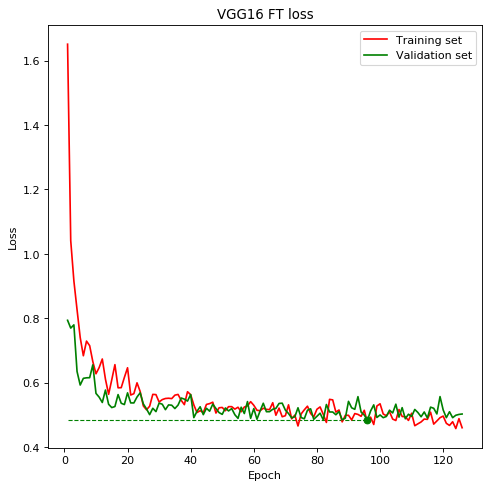

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [22]:
vgg16_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg16_calc_benign_or_malignant_best_RMSprop.h5')

for layer in vgg16_calc_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [24]:
history_fit = vgg16_calc_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5185 - recall: 0.7266
Epoch 00001: val_loss improved from inf to 0.62538, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5123 - recall: 0.7234 - val_loss: 0.6254 - val_recall: 0.7427
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4668 - recall: 0.7500
Epoch 00002: val_loss improved from 0.62538 to 0.50390, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.4551 - recall: 0.7568 - val_loss: 0.5039 - val_recall: 0.7590
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4554 - recall: 0.7559
Epoch 00003: val_loss did not improve from 0.50390
5/5 [==============================] - 10s 2s/step - loss: 0.4422 - recall: 0.

Epoch 00060: early stopping


In [25]:
models.save_model(vgg16_calc_benign_or_malignant_fine_RMSprop, '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 60
Epoch [opt]: 30
Valid accuracy [end]: 0.7362
Valid accuracy [opt]: 0.7655
Test accuracy [end]:  0.7389
Test accuracy [opt]:  0.7270
Valid loss [end]: 0.6192
Valid loss [opt]: 0.4733
Test loss [end]:  0.5908
Test loss [opt]:  0.5831


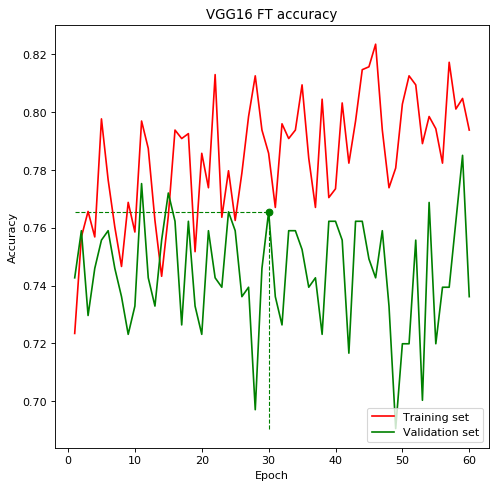

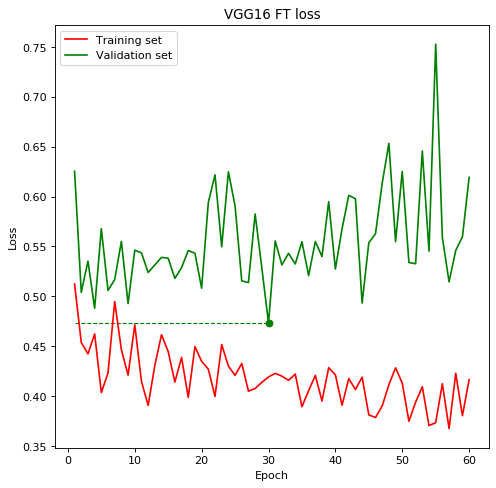

In [27]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [13]:
vgg16_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best.h5')

for layer in vgg16_calc_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [15]:
history_fit = vgg16_calc_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.6318 - recall: 0.6609
Epoch 00001: val_loss improved from inf to 0.59419, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 17s 3s/step - loss: 0.6437 - recall: 0.6735 - val_loss: 0.5942 - val_recall: 0.6710
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5180 - recall: 0.7344
Epoch 00002: val_loss improved from 0.59419 to 0.53377, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5231 - recall: 0.7172 - val_loss: 0.5338 - val_recall: 0.7362
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5107 - recall: 0.7188
Epoch 00003: val_loss did not improve from 0.53377


Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4588 - recall: 0.7696
Epoch 00028: val_loss did not improve from 0.47274
5/5 [==============================] - 10s 2s/step - loss: 0.4470 - recall: 0.7823 - val_loss: 0.5404 - val_recall: 0.7557
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4297 - recall: 0.7578
Epoch 00029: val_loss did not improve from 0.47274
5/5 [==============================] - 10s 2s/step - loss: 0.4163 - recall: 0.7734 - val_loss: 0.6822 - val_recall: 0.7166
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4157 - recall: 0.7871
Epoch 00030: val_loss did not improve from 0.47274
5/5 [==============================] - 10s 2s/step - loss: 0.4175 - recall: 0.7844 - val_loss: 0.5122 - val_recall: 0.7296
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3986 - recall: 0.7871
Epoch 00031: val_loss did not improve from 0.47274
5/5 [==============================] - 11s 2s/step - loss: 

In [16]:
models.save_model(vgg16_calc_benign_or_malignant_fine_RMSprop2, '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_end2.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 53
Epoch [opt]: 23
Valid accuracy [end]: 0.7590
Valid accuracy [opt]: 0.7427
Test accuracy [end]:  0.6944
Test accuracy [opt]:  0.7359
Valid loss [end]: 0.6308
Valid loss [opt]: 0.4727
Test loss [end]:  0.6616
Test loss [opt]:  0.5467


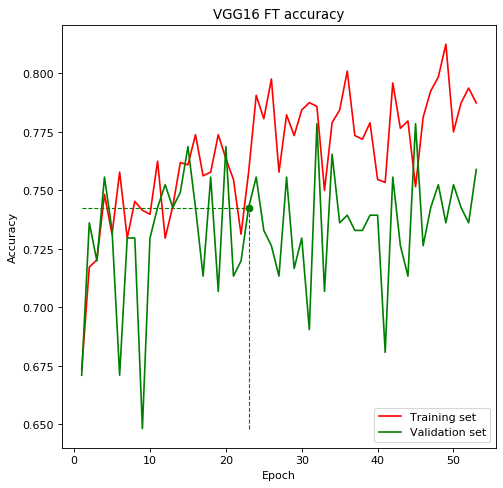

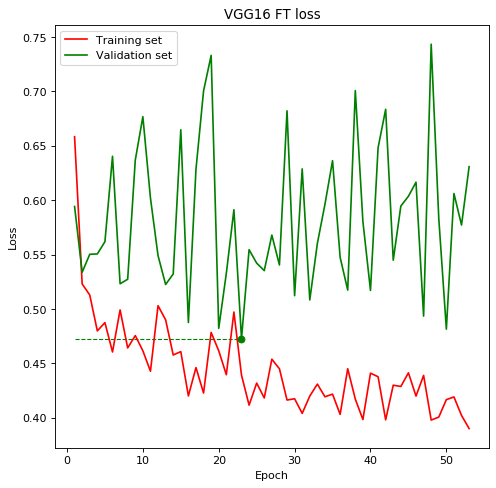

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [19]:
vgg16_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in vgg16_calc_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [21]:
history_fit = vgg16_calc_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5379 - recall: 0.7363
Epoch 00001: val_loss improved from inf to 0.68913, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5273 - recall: 0.7375 - val_loss: 0.6891 - val_recall: 0.7264
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4811 - recall: 0.7304
Epoch 00002: val_loss improved from 0.68913 to 0.55479, saving model to ../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.4723 - recall: 0.7381 - val_loss: 0.5548 - val_recall: 0.7590
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4748 - recall: 0.7674
Epoch 00003: val_loss did not improve from 0.55479
5/5 [==============================] - 10s 2s/step - loss: 0.4715 - recall: 

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4031 - recall: 0.7739
Epoch 00029: val_loss did not improve from 0.49335
5/5 [==============================] - 10s 2s/step - loss: 0.4183 - recall: 0.7704 - val_loss: 0.5490 - val_recall: 0.7264
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3886 - recall: 0.8086
Epoch 00030: val_loss did not improve from 0.49335
5/5 [==============================] - 10s 2s/step - loss: 0.3913 - recall: 0.8016 - val_loss: 0.6350 - val_recall: 0.7199
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3860 - recall: 0.8000
Epoch 00031: val_loss did not improve from 0.49335
5/5 [==============================] - 11s 2s/step - loss: 0.4093 - recall: 0.8010 - val_loss: 0.6111 - val_recall: 0.7492
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4079 - recall: 0.7773
Epoch 00032: val_loss did not improve from 0.49335
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3900 - recall: 0.8359
Epoch 00060: val_loss did not improve from 0.47813
5/5 [==============================] - 10s 2s/step - loss: 0.3967 - recall: 0.8313 - val_loss: 0.5034 - val_recall: 0.7655
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3748 - recall: 0.8281
Epoch 00061: val_loss did not improve from 0.47813
5/5 [==============================] - 10s 2s/step - loss: 0.3711 - recall: 0.8219 - val_loss: 0.5594 - val_recall: 0.7362
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3778 - recall: 0.8047
Epoch 00062: val_loss did not improve from 0.47813
5/5 [==============================] - 10s 2s/step - loss: 0.3796 - recall: 0.8047 - val_loss: 0.6726 - val_recall: 0.7459
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3908 - recall: 0.8086
Epoch 00063: val_loss did not improve from 0.47813
5/5 [==============================] - 10s 2s/step - loss: 

In [22]:
models.save_model(vgg16_calc_benign_or_malignant_fine_RMSprop3, '../model/vgg16_calc_benign_or_malignant_fine_RMSprop_end3.h5')

In [23]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg16_calc_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = vgg16_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 81
Epoch [opt]: 51
Valid accuracy [end]: 0.7524
Valid accuracy [opt]: 0.7687
Test accuracy [end]:  0.7211
Test accuracy [opt]:  0.7062
Valid loss [end]: 0.6946
Valid loss [opt]: 0.4781
Test loss [end]:  0.7144
Test loss [opt]:  0.5356


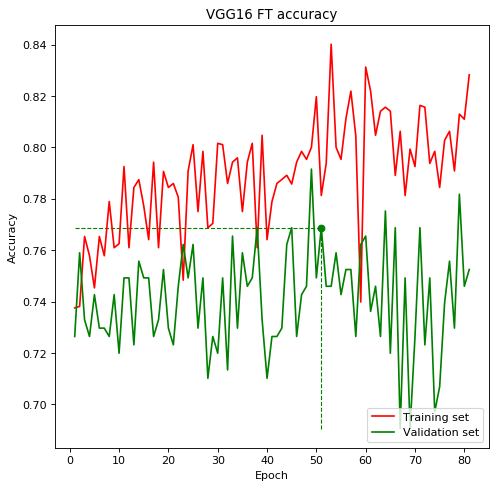

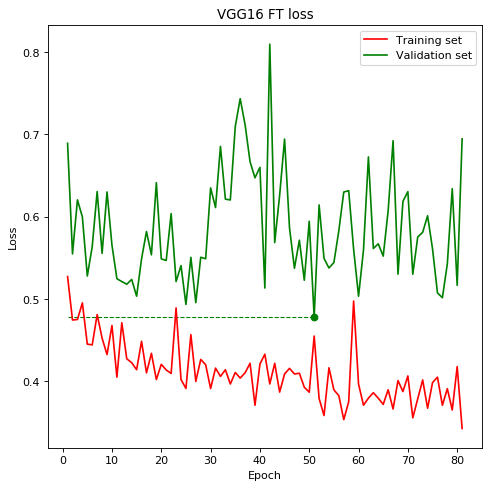

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();